In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/jupyter/ark_dev')

from marker_quantification import compute_marker_counts,create_marker_count_matrices
from marker_quantification import create_marker_count_matrix_mp


import dask
from dask.distributed import Client
import timeit
from glob import glob

In [2]:
import ark
from ark.utils.load_utils import load_imgs_from_dir
from ark.segmentation.marker_quantification import compute_marker_counts,generate_cell_table, create_marker_count_matrices
import deepcell
from deepcell.applications import Mesmer

import xarray
import skimage.io as io
from skimage.io import imread
import os
import pandas as pd
import tifffile
from tifffile import TiffFile
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

qptiff_channels = ['dapi', 'foxp3', 'tumor_specific', 'cd8', 'pd1', 'pdl1','autofluorescence']


def extract_patches_mod(imarr, patchsize, channels=3, stride=None):
    """
    Extract patches from an image. Allows user to specify stride between patches.
    If no stride is specified, defaults to stride = patchsize for non-overlapping patches. Based on
    `original implementation <https://github.com/scikit-learn/scikit-learn/blob/95d4f0841d57e8b5f6b2a570312e9d832e69debc/sklearn/feature_extraction/image.py#L244>`_
    in sklearn.


    :param imarr: Image array, RGB format
    :type imarr: numpy.ndarray
    :param patchsize: Dimension of extracted patches
    :type patchsize: int
    :param stride: Stride length between patches, defaults to None
    :type stride: int, optional
    :return: Array of extracted patches, stacked along new axis, shape (npatches, patchsize, patchsize, channels)
    :rtype: numpy.ndarray
    """
    if stride is None:
        stride = patchsize

    patch_strides = imarr.strides
    patch_shape = (patchsize, patchsize, channels)
    extraction_step = (stride, stride, 1)
    slices = tuple(slice(None, None, st) for st in extraction_step)
    indexing_strides = imarr[slices].strides
    patch_indices_shape = ((np.array(imarr.shape) - np.array(patch_shape)) //
                           np.array(extraction_step)) + 1
    shape = tuple(list(patch_indices_shape) + list(patch_shape))
    strides = tuple(list(indexing_strides) + list(patch_strides))
    print(patch_indices_shape)
    print(imarr.shape, shape)
    patches = np.lib.stride_tricks.as_strided(imarr, shape=shape, strides=strides)

    return patches.squeeze(2)  # retain tiling shape

################################################################################################################################################################################################ 
################################################################################################################################################################################################ 
################################################################################################################################################################################################ 


In [5]:
candidates = pd.read_csv('./immunoprofile_hne_rag_features__passing_14_subset.csv', index_col=0)

prev_data = pd.read_pickle('ccrcc_ip14_arcsinh_quant_agg_with_basic_cutoffs.pkl')

In [7]:
import seaborn as sns

def set_rc(x=10,y=10, font_scale=1., style='white', font='Arial', **kwargs):
    sns.set(rc={'figure.figsize':[x,y]}, font_scale=font_scale, style=style, font=font, **kwargs)
    
set_rc()

IP_19_R00053
fitting KNR


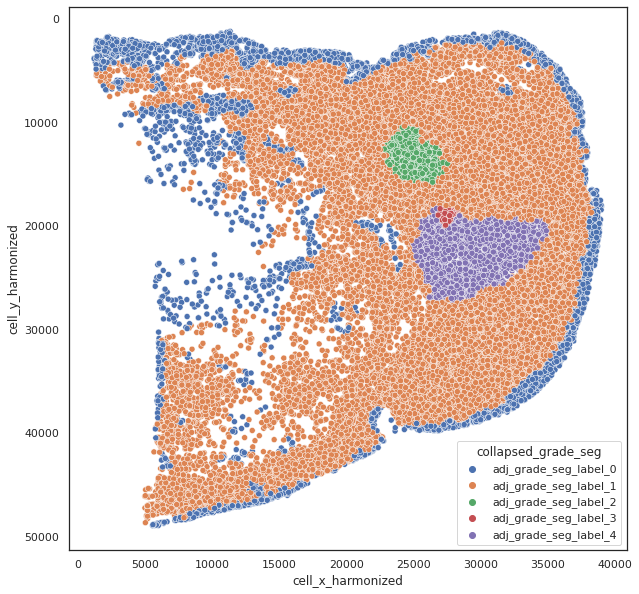

IP_19_D00209
fitting KNR


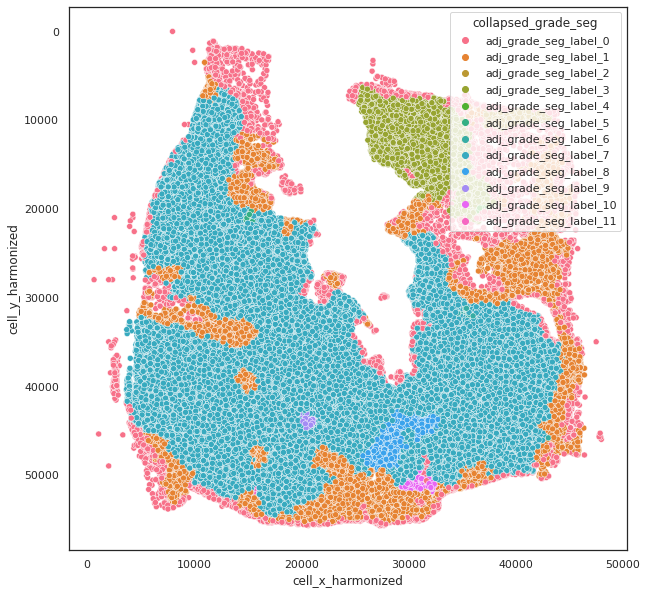

IP_19_G00660
fitting KNR


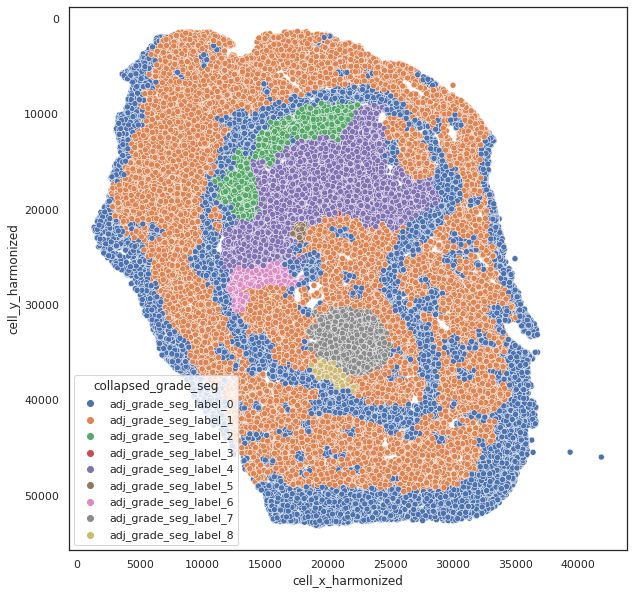

IP_20_J00195
fitting KNR


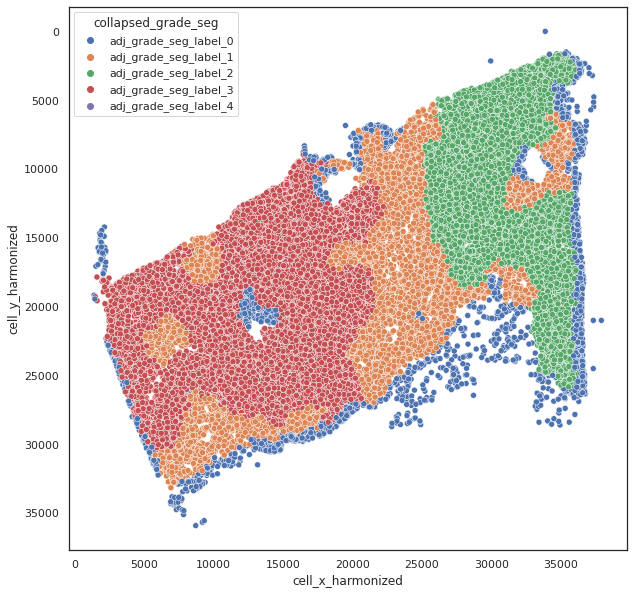

IP_20_F00356
fitting KNR


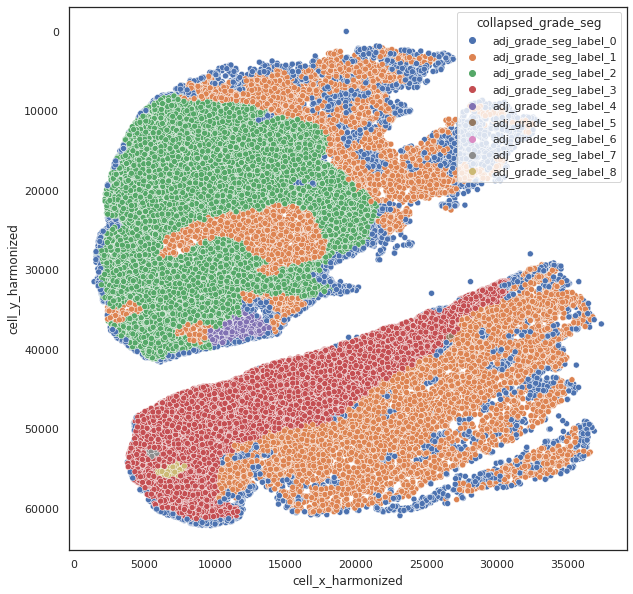

IP_19_E00218
fitting KNR


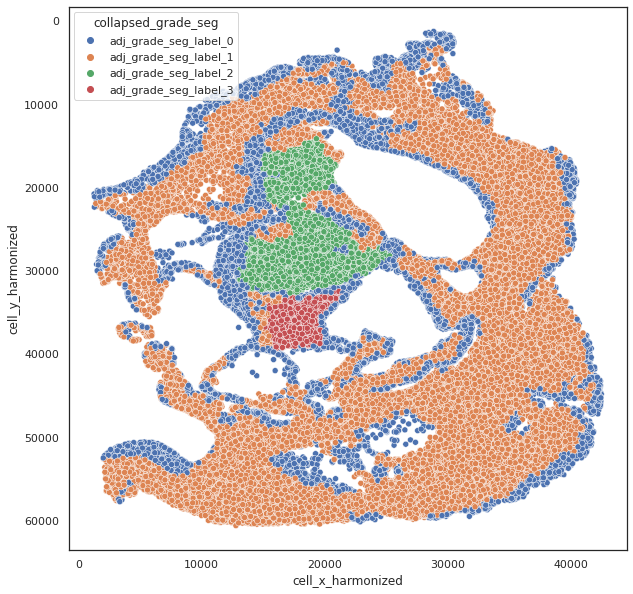

IP_18_A00093
fitting KNR


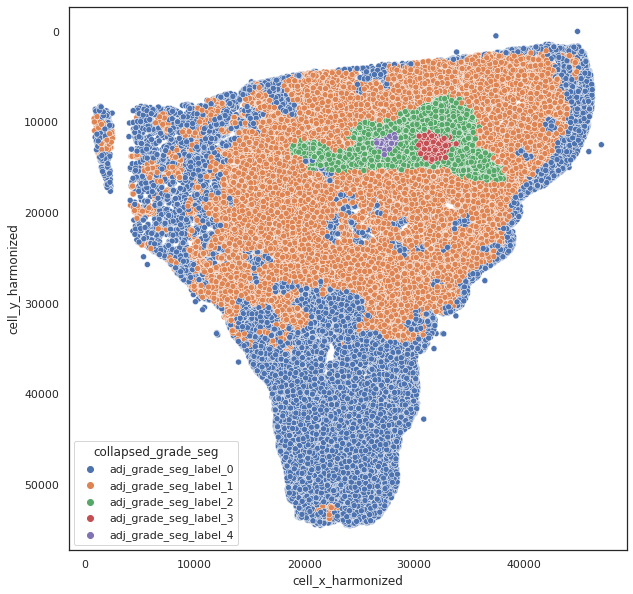

IP_19_J00132
fitting KNR


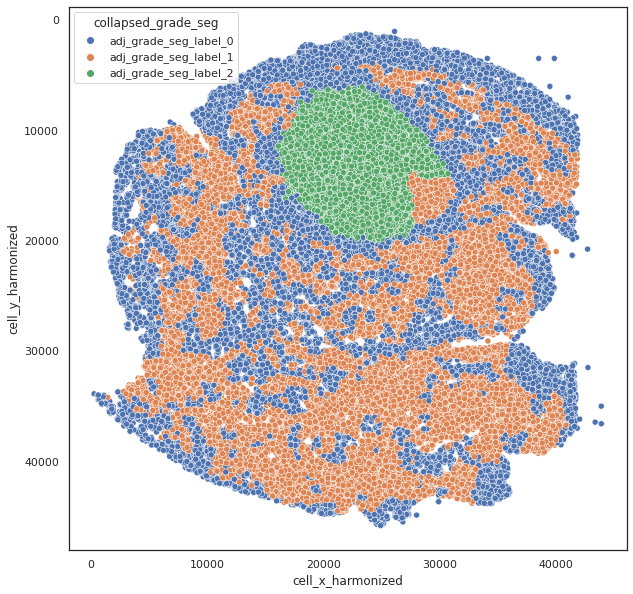

IP_20_M00245
fitting KNR


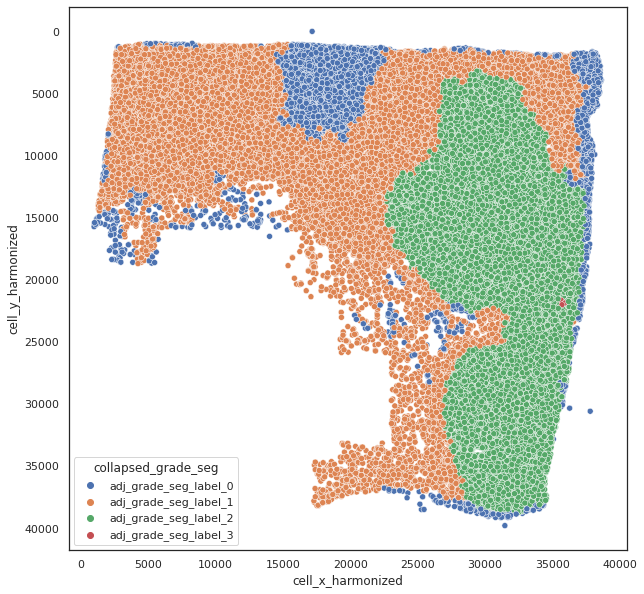

IP_19_K00367
fitting KNR


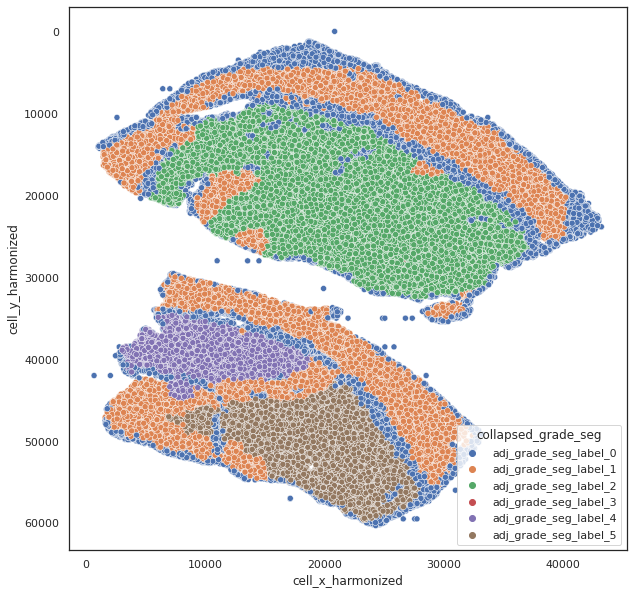

IP_19_T00810
fitting KNR


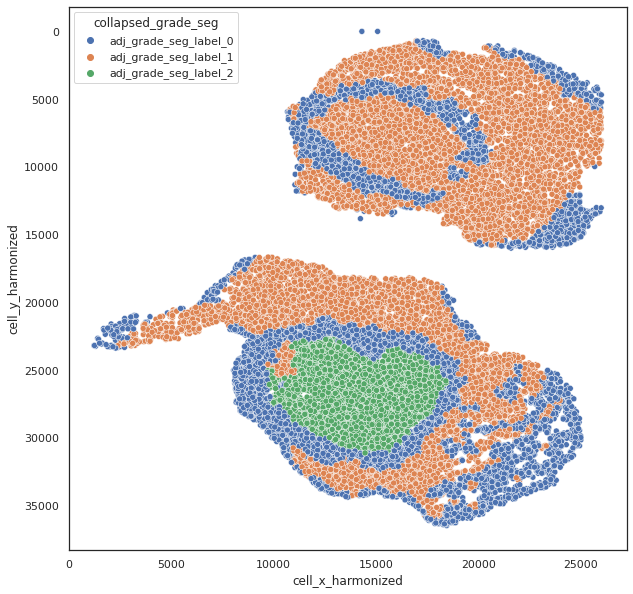

IP_19_F00568
fitting KNR


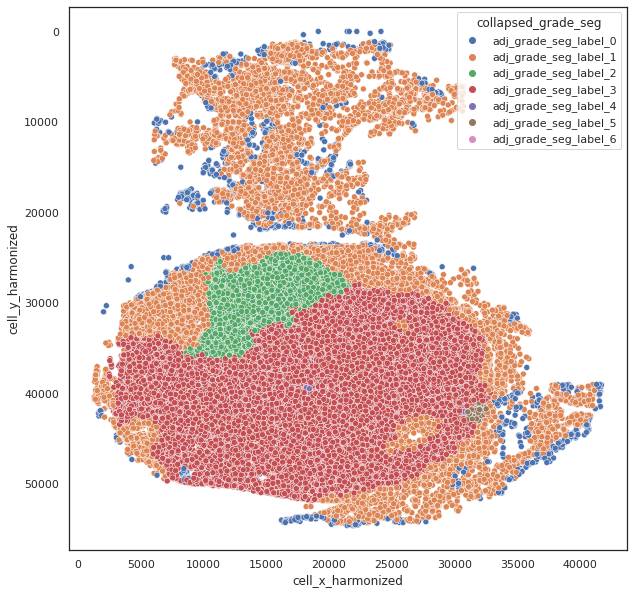

IP_19_K00058
fitting KNR


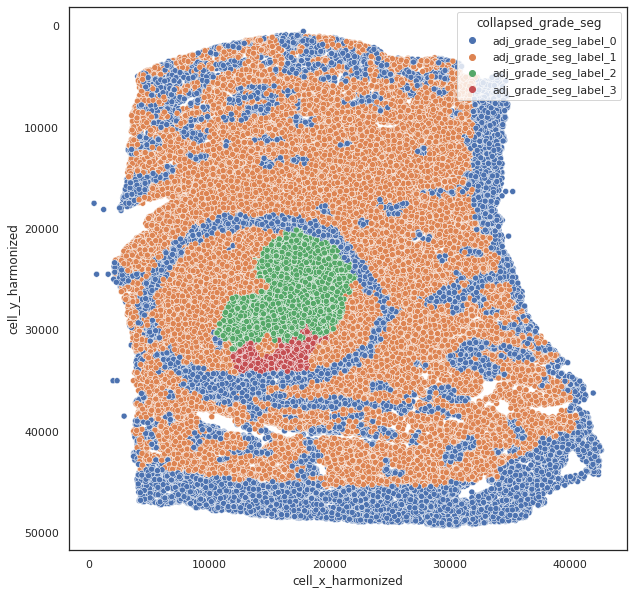

IP_19_G00562
fitting KNR


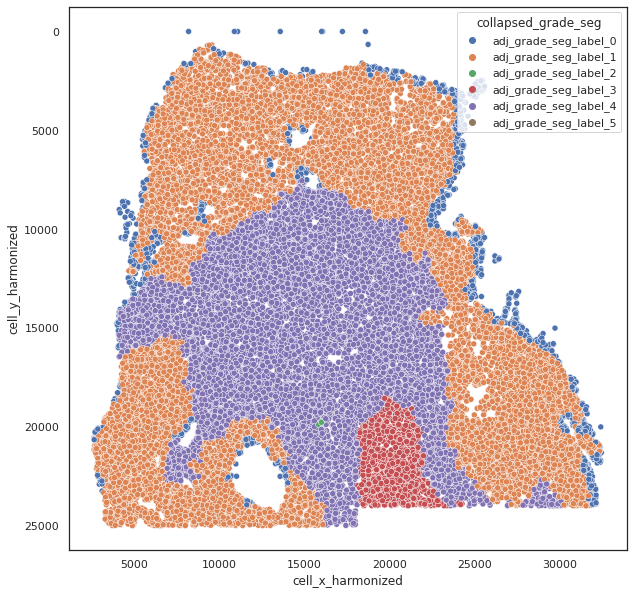

In [12]:
from sklearn.neighbors import KNeighborsRegressor

n_neighbors = 8
dist_type = 'uniform'

agg = pd.DataFrame()

for case_id in candidates.sample(frac=1).index.values:
    print(case_id)
    f = f'/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/displaced_trimmed_grade_seg_maps/{case_id}_knr_map.pkl'
    grade_knr_map = pd.read_pickle(f).sample(frac=0.01)
    
    sub = prev_data.loc[[case_id]]

    # flip incorrect x/y 
    sub['cell_y_full_scale'] = sub['fov_y_full_scale'] + sub['centroid-1']
    sub['cell_x_full_scale'] = sub['fov_x_full_scale'] + sub['centroid-0']
    
    sub['cell_x_harmonized'] = sub['cell_y_full_scale']
    sub['cell_y_harmonized'] = sub['cell_x_full_scale']

    knr = KNeighborsRegressor(n_neighbors=n_neighbors, weights=dist_type)
    
    print('fitting KNR')
    label_dummies = pd.get_dummies(grade_knr_map['label'], prefix='adj_grade_seg_label')
    grade_knr_map = pd.concat([grade_knr_map,label_dummies],1)
    
    for seg_col in label_dummies.columns:
        knr.fit(grade_knr_map[['x','y']].values, grade_knr_map[seg_col].values)
        knr_preds = knr.predict(sub[['cell_x_harmonized','cell_y_harmonized']].values)
        # sub[seg_col] = np.ceil(knr_preds)
        sub[seg_col] = knr_preds
        
    sub['collapsed_grade_seg'] = sub[label_dummies.columns].idxmax(1)
    g = sns.scatterplot(y='cell_y_harmonized',x='cell_x_harmonized', data=sub.sample(frac=0.05), 
                        hue='collapsed_grade_seg', hue_order=label_dummies.columns)
    g.invert_yaxis()
    plt.show()

    agg = agg.append(sub.drop(columns=label_dummies.columns))



In [15]:
agg.to_pickle('ccrcc_ip14_arcsinh_quant_agg_with_basic_cutoffs__rerun_correct_grade_seg.pkl')